# Mark and Recapture 

We take the earlier developed model of "Commited moose" (the ones that move in a straight line, and get reflected by enclosure borders). But also even before starting the movement, we mark all animals in one corner. It's like as if we captured them, marked them, and released them.

And then at some point in time we trap them again (look at all animals in this corner), count how many of them are marked (how many of them were captured before), and use this info to estimate the number of animals in the system.

(Here we of course have the God-like knowledge of the true number of animals in the system, so what we are trying to check is whether an estimation an ecologist would have made would have been reasonable.)

We'll use the following formula for the estimation (taken from Wikipedia): ${\displaystyle {\hat {N}}_{C}={\frac {(K+1)(n+1)}{k+1}}-1}$

And then, in practice, we'll make our 'fake ecologist' estimate the number of animals in the system at every step of the loop. Not because they would do so in practice (in practice they would have waited for some time of course, and then they would have re-traped the animals once or twice), but just because we can do it. And it can lead to useful predictions, like, when should an ecologist retrap the animals? How long should they wait?

Changes vs previous version:
* All constants moved from global variables to a class, as class properties
* The model is made into a function
* The "running dotses" visualization is made conditional (so we haven't deleted it completely), but it is now inactivated by default

In [3]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
#Define constants, but we do it as a class (to later make passing it around easier)

class Const:
    def __init__(self):
        self.n_animals_max = 1000
        self.n_animals_start = 20  #Original n_animals
        self.n_steps = 400
        self.vmin = 0.01
        self.vmax = 0.05
        self.v_decay = 0.7 #To make movement more realistic
        
        self.hp_baby = 10
        self.hp_food = 5
        self.hp_reproduction = 50
        self.hp_birthcost = 30
        self.hp_leak = 0.5
        
        self.food_rate = 1
        self.eating_distance = 0.05
        self.n_food_max = 1000
        self.n_food_start = 100
        

In [5]:
#Build the model
def model(c, show_dotses=False, n_trials=1):
    history = np.zeros((c.n_steps, n_trials))

    for i_trial in range(n_trials):
        #Allocate hp for all animals, but only first few are alive
        hp = np.zeros(c.n_animals_max)
        hp[:c.n_animals_start] = np.random.uniform(
            low=c.hp_baby, high=c.hp_reproduction, size=c.n_animals_start)
        
        x = np.random.uniform(size=c.n_animals_max)
        y = np.random.uniform(size=c.n_animals_max)
        vx = np.random.uniform(size=c.n_animals_max, low=c.vmin, high=c.vmax)*(
            2*np.random.randint(size=c.n_animals_max,low=0,high=2) - 1)
        vy = np.random.uniform(size=c.n_animals_max, low=c.vmin, high=c.vmax)*(
            2*np.random.randint(size=c.n_animals_max,low=0,high=2) - 1)
        
        #Let there be cabbage!
        foodx = np.ones(c.n_food_max)*-1
        foodx[:c.n_food_start] = np.random.uniform(size=c.n_food_start)
        foody = np.random.uniform(size=c.n_food_max) 
        #Y doen't matter coz x=-1 is enough to move cabbage out of this world
        
        n_animals = np.zeros(c.n_steps)

        if show_dotses: #Init plots
            fig = plt.figure(figsize=(3,3))
            ax = plt.subplot(111) #No subplots; just creating axes
            plt.xlim((0,1));
            plt.ylim((0,1));
            fig.show()
            fig.canvas.draw()

        for t in range(c.n_steps):
            x += vx
            y += vy
            
            vx = vx*c.v_decay + np.random.randn(c.n_animals_max)*c.vmin 
            vy = vy*c.v_decay + np.random.randn(c.n_animals_max)*c.vmin
            #Make them run around (keeps speed somewhat randomized)

            # Reflect from the walls
            vx = np.where(np.logical_or(x>1,x<0), -vx , vx)
            vy = np.where(np.logical_or(y>1,y<0), -vy , vy)
            x = np.maximum(0,np.minimum(x,1)) #Keep them in enclosure
            y = np.maximum(0,np.minimum(y,1))
            
            for i_animal in range(c.n_animals_max):
                if hp[i_animal]<=0: # Skip dead animals
                    continue
                #Version with a loop:
                for i_food in range(c.n_food_max):
                    if foodx[i_food]<0: #This makes things faster
                        continue
                    d = np.sqrt((x[i_animal]-foodx[i_food])**2 + (y[i_animal]-foody[i_food])**2)
                    if d < c.eating_distance:
                        hp[i_animal] += c.hp_food
                        foodx[i_food] = -1
                
            #Let cabbage grow!
            potential_cabbage = np.argwhere(foodx<0)
            if potential_cabbage.size != 0:
                foodx[potential_cabbage[0]] = np.random.uniform()
                foody[potential_cabbage[0]] = np.random.uniform()
                
            hp -= c.hp_leak #Death
            
            n_animals[t] = np.sum(hp>0)
            
            #Animals making babies
            possible_animal_babies = np.argwhere(hp>c.hp_reproduction)
            if possible_animal_babies.size !=0: #If we have fewer than the maximum number of babies
                animal_babies = np.argwhere(hp <= 0) #For every animal
                hp[possible_animal_babies[0]] -= c.hp_birthcost #If its health is above a certain value
                x[animal_babies[0]] = x[possible_animal_babies[0]] #Reduce health
                y[animal_babies[0]] = y[possible_animal_babies[0]] #Find dead animal 
                hp[animal_babies[0]] = c.hp_baby #New baby; set initial position to that of parent and give speed+health   
        
            if show_dotses: #Actual animation
                ax.clear()
                plt.plot(x[hp>0], y[hp>0], 'k.',markersize=5);
                plt.plot(foodx,foody,'r.', markersize=2)
                plt.xlim((0,1));
                plt.ylim((0,1));
                fig.canvas.draw() #Redraws the canvas (key secret command to animate things)
        #The time loop is over

        history[:,i_trial] = n_animals
    return np.mean(history, axis=1)

<IPython.core.display.Javascript object>


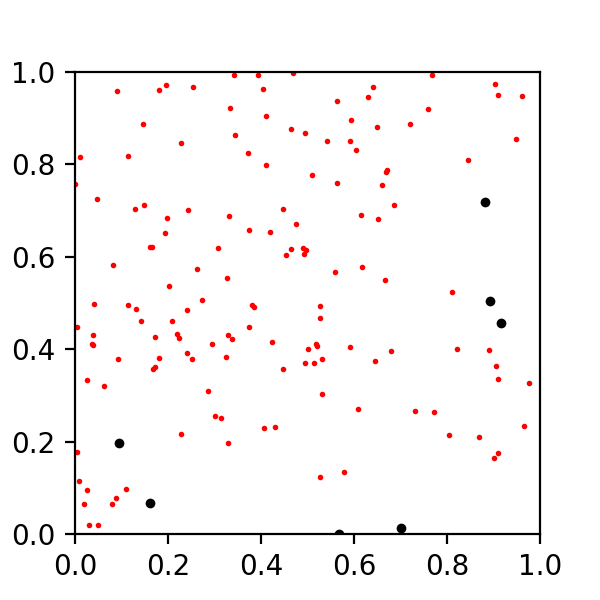

<IPython.core.display.Javascript object>


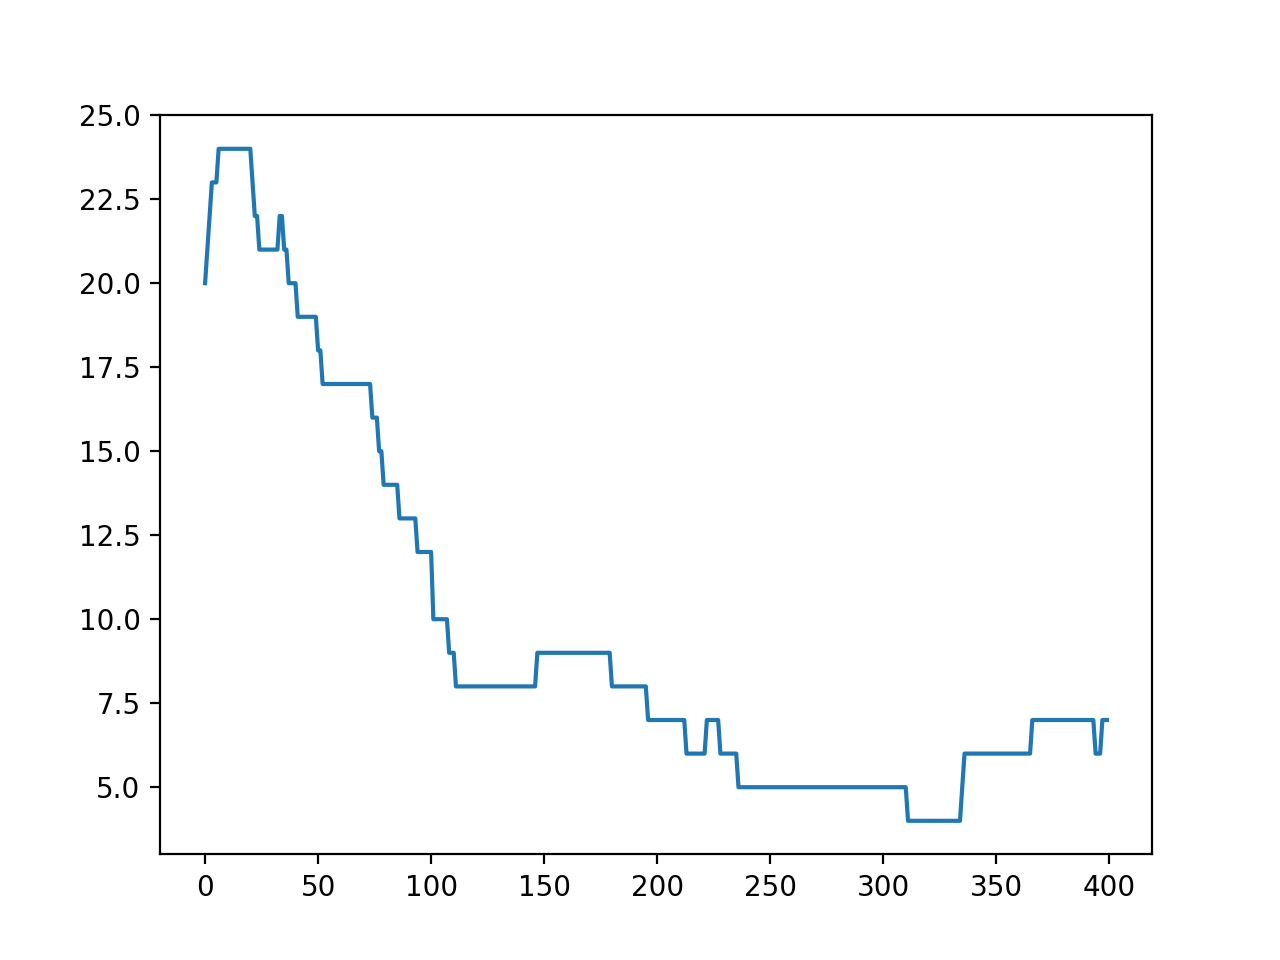

In [7]:
#Main program
c = Const();
curve  = model(c, show_dotses=True);
plt.figure();
plt.plot(curve);

* In my model, I found that with my current parameters, the population of rabbits becomes very close to zero, and at the last second, they begin to have babies and the population slowly is rising again. 